In [4]:
%matplotlib notebook
import sys
# add path to pair interaction installation
# see pairinteraction.github.io
sys.path.append('../pairinteraction/build')
from cycler import cycler
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from libpairinteraction import pireal as pi
cache_dir = './cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

In [31]:
distances = np.linspace(14, 4, 200)  # mu
efields = [0, 0.020]  # V/cm
bfield = 6.9  # gauss
angle = 78*np.pi/180  # rad

In [32]:
state_one = pi.StateOne('Rb', 61, 2, 1.5, 1.5)
state_two = pi.StateTwo(state_one, state_one)

In [33]:
def setup_system_one(bfield, efield):
    system_one = pi.SystemOne(state_one.element, cache_dir)
    system_one.restrictEnergy(state_one.energy-30, state_one.energy+30)
    system_one.restrictN(state_one.n-2, state_one.n+2)
    system_one.restrictL(state_one.l-2, state_one.l+2)
    system_one.setBfield([0, 0, bfield])
    system_one.setEfield([0, 0, efield])
    return system_one

In [34]:
def setup_system_two(system_one, distance, angle):
    system_two = pi.SystemTwo(system_one, system_one, cache_dir)
    system_two.restrictEnergy(state_two.energy-1, state_two.energy+1)
    system_two.setDistance(distance)
    system_two.setAngle(angle)
    if angle == 0:
        system_two.setConservedMomentaUnderRotation([int(2*state_one.m)])
    system_two.setConservedParityUnderPermutation(pi.ODD)
    return system_two

In [36]:
def getSystems(distance, system_one, angle, fieldshift):
    # Set up two atom system
    system_two = setup_system_two(system_one, distance, angle)
    system_two.diagonalize()

    # Restrict the calculated eigenenergies
    system_two.restrictEnergy(fieldshift-0.015, fieldshift+0.015)
    system_two.buildHamiltonian() # has to be called to apply the new restriction in energy

    return system_two    

<IPython.core.display.Javascript object>


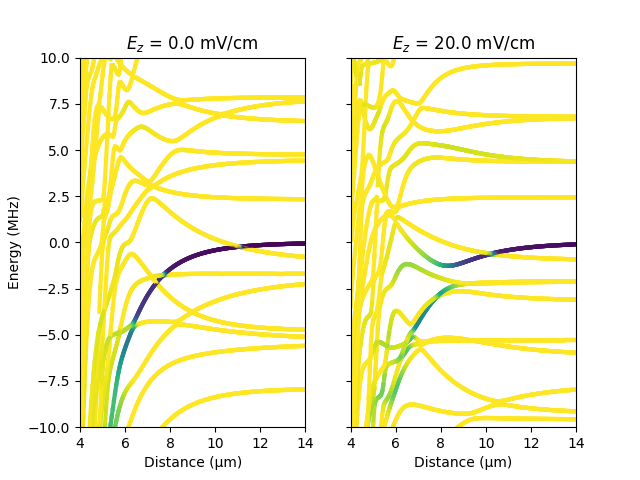

In [37]:
fig = plt.figure()
axes = [fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)]

for ax, efield in zip(axes, efields):
    # Set up one atom systems
    system_one = setup_system_one(bfield, efield)
    system_one.diagonalize()
    fieldshift = 2*system_one.diagonal[system_one.getVectorindex(state_one)]

    # Get diagonalized two atom systems
    systems_two = list(map(partial(getSystems, system_one=system_one, angle=angle, fieldshift=fieldshift), distances))

    # Plot pair potentials
    ax.set_title(r"$E_z$ = ${}$ mV/cm".format(efield*1e3))
    ax.set_xlabel(r"Distance (µm)")
    ax.set_xlim(np.min(distances),np.max(distances))
    ax.set_ylim(-10, 10)

    for i1, i2 in zip(range(0, len(systems_two)-1), range(1, len(systems_two))):
        c1, c2 = np.array(systems_two[i1].getConnections(systems_two[i2], 0.001))
        segment_distances = [distances[i1],distances[i2]]
        segment_energies = (np.array([systems_two[i1].diagonal[c1],
                                      systems_two[i2].diagonal[c2]])-fieldshift)*1e3 # MHz
        segment_overlap = np.mean([systems_two[i1].getOverlap(state_two)[c1],
                                   systems_two[i2].getOverlap(state_two)[c2]], axis = 0)
        segment_color = plt.cm.viridis_r(segment_overlap)
        ax.set_prop_cycle(cycler('color', segment_color))
        ax.plot(segment_distances, segment_energies, lw=3)

axes[0].set_ylabel(r"Energy (MHz)")
axes[1].set_yticklabels([]);